# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [1]:
import qiskit

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

In [4]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_58907/3415147788.py:4: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


##### Example of 3d system

In [17]:
#class input parameters:
n_sites = [2,2,2]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [18]:
latt = HCLattice(n_sites,pbc=pbc)


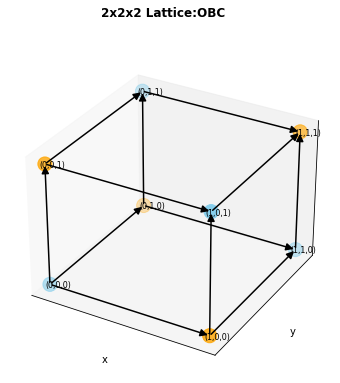

In [19]:
latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)

In [20]:
hamilt_sym = HamiltonianQED_sym(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

class_H_oprt = HamiltonianQED_oprt(
                        latt,
                        hamilt_sym,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.03630709648132324 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 2.0961029529571533 seconds
>> Suppression term built.  Execution time: 0.008333683013916016 seconds


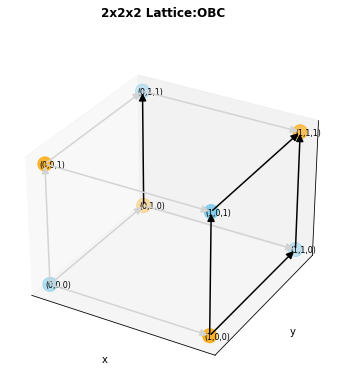

In [21]:

#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [10]:
def sparse_mem2(sparsem):
    """Return the memory in GiB of a sparse matrix"""
    return (sparsem.data.nbytes + sparsem.indptr.nbytes + sparsem.indices.nbytes)/1024**3

##### ED spectrum

In [22]:
import scipy.sparse as sp

In [23]:
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H_oprt.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
#spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of {latt.dims}D_'+'x'.join([str(i) for i in n_sites])+f'H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_L{L}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))

if class_H_oprt.len_e_op != 0:
    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()#.conj().T
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list) 
    print(f'plaq={plaq}')
                
                         

0.00011928 Gb
Spectrum of 3D_2x2x2H with mbasisFalsepuregaugeTrue pbcFalse_g0.5_l1_L8_factE1_factB1_m3_Omega1, encoding:gray
E_0= -13.77252346
E_1= -11.01902055
E_2= -10.1313371
plaq=0.6129908746976278


### Example static potential

In [13]:
#class input parameters:
n_sites = [3,3]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):-1,(2,1):1}
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

#************* lattice
latt = HCLattice(n_sites,pbc=pbc)

latt.func_qstatic_dist()#charge=(1,0))

static_charges_values_input = latt.distances_coord
print(static_charges_values_input,latt.r_list)

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (1, 0): 1} {(0, 0): -1, (1, 2): 1}
 {(0, 0): -1, (2, 1): 1}] [1.0 1.0 2.23606797749979 2.23606797749979]


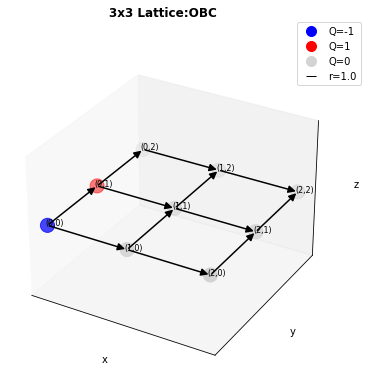

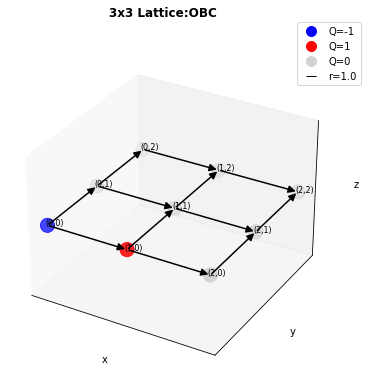

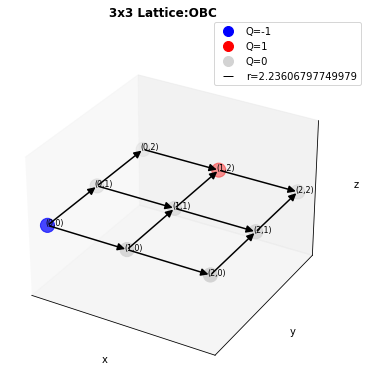

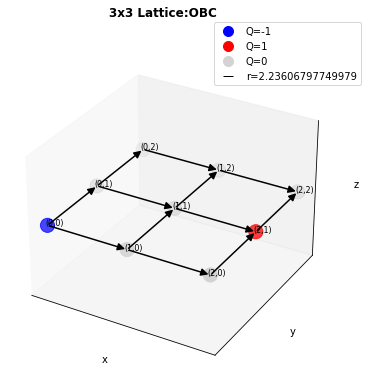

[None, None, None, None]

In [15]:
#Define all possible static charge config.
[latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values) for static_charges_values in static_charges_values_input]

In [16]:
for qstatic in static_charges_values_input:
    hamilt_sym = HamiltonianQED_sym(
                            latt,
                            n_sites,
                            l,
                            ll=L,
                            encoding = encoding,
                            rotors=rotors,
                            magnetic_basis=magnetic_basis,
                            pbc=pbc,
                            puregauge=puregauge,
                            static_charges_values=qstatic,
                            e_op_out_plus = e_op_out_plus,
                            display_hamiltonian=display_hamiltonian)

    class_H_oprt = HamiltonianQED_oprt(
                            latt,
                            hamilt_sym,
                            n_sites,
                            l,
                            ll=L,
                            encoding = encoding,
                            rotors=rotors,
                            magnetic_basis=magnetic_basis,
                            pbc=pbc,
                            puregauge=puregauge,
                            static_charges_values=qstatic,
                            e_op_out_plus = e_op_out_plus)

    Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
    if encoding=='gray':
        Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
        h_b_sparse = class_H_oprt.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
    elif encoding=='ed':
        Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
        h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
    #spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
    spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
    #spectrum
    idx = spectrum.argsort() 
    spectrum = spectrum[idx]
    eigenvectors_matrix = eigenvectors_matrix[:,idx]
    print(f'Spectrum of {latt.dims}D_'+'x'.join([str(i) for i in n_sites])+f'H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_L{L}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
    for kk,evalu in enumerate(spectrum):
            if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                    print(f'E_{kk}=',round(evalu,8))



HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.0204470157623291 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 1.943652868270874 seconds
>> Suppression term built.  Execution time: 0.0062482357025146484 seconds
Spectrum of 2D_3x3H with mbasisFalsepuregaugeTrue pbcFalse_g0.5_l1_L8_factE1_factB1_m3_Omega1, encoding:gray
E_0= -9.15455739
HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.013187885284423828 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 1.9988090991973877 seconds
>> Suppression term built.  Execution time: 0.010816812515258789 seconds
Spectrum of 2D_3x3H with mbasisFalsepurega